# Proyecto Fase 1: Optimización de la Distribución de Cámaras de Seguridad mediante Clustering y MST en el Centro de León, Guanajuato

- Luis Pablo López Iracheta

## Obtención del grafo de la ciudad

In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Circle
import contextily as ctx
import numpy as np
import heapq

G = ox.graph_from_point((21.122, -101.682), dist=2000, network_type='drive')
ox.save_graphml(G, "Centro_Leon_Guanajuato.graphml") 


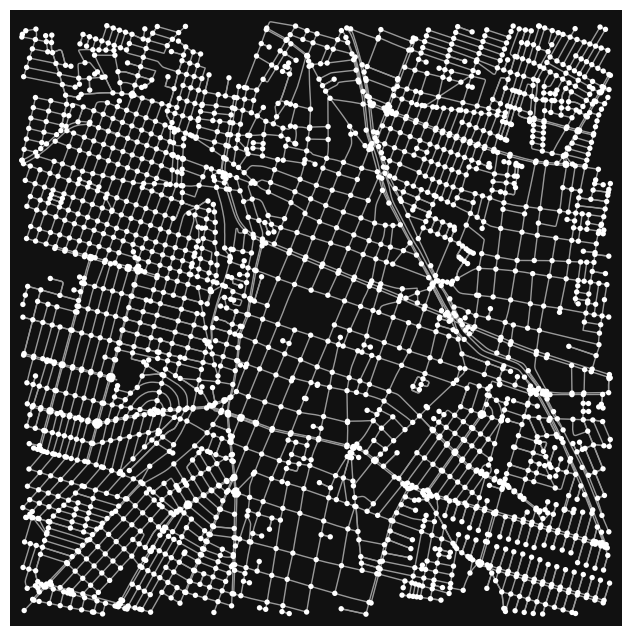

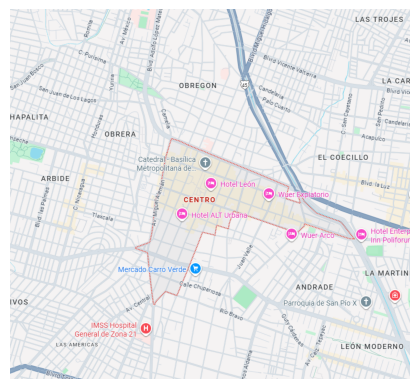

In [2]:
# Mostrar el mapa y grafo
G = ox.load_graphml("Centro_Leon_Guanajuato.graphml")
ox.plot_graph(G)
# mapa de maps
maps = "Centro_Leon_GTO_MAPS.png"

img = plt.imread(maps)
plt.imshow(img)
plt.axis('off')
plt.show()


In [3]:
# Obtenemos las coordenadas de los nodos
lats = [G.nodes[node]['y'] for node in G.nodes]
lons = [G.nodes[node]['x'] for node in G.nodes]

# Dimensiones
min_lat, max_lat = min(lats), max(lats)
min_lon, max_lon = min(lons), max(lons)

# Dimensiones en grados
ancho_grados = max_lon - min_lon
alto_grados = max_lat - min_lat

# Convertir dimensiones a metros
latitud_media = (min_lat + max_lat) / 2
ancho_metros = ancho_grados * 111000 * math.cos(math.radians(latitud_media))
alto_metros = alto_grados * 111000
area_metros_cuadrados = ancho_metros * alto_metros
area_km_cuadrados = area_metros_cuadrados / 1e6 # se divide entre 1,000,000 para convertir a km2

print(f"Cantidad de nodos: {len(G.nodes)}  y aristas: {len(G.edges)}")
print(f"Coordenadas: {min_lat:.4f}° a {max_lat:.4f}° N, {min_lon:.4f}° a {max_lon:.4f}° W")
print(f"Dimensiones en grados: {ancho_grados:.4f}° x {alto_grados:.4f}°")
print(f"Dimensiones en metros: {ancho_metros:.1f} m x {alto_metros:.1f} m")
print(f"Área total: {area_km_cuadrados:.2f} km2")
print(f"Radio aproximado: {math.sqrt(area_km_cuadrados):.2f} km")

Cantidad de nodos: 2658  y aristas: 4940
Coordenadas: 21.1040° a 21.1400° N, -101.7013° a -101.6627° W
Dimensiones en grados: 0.0385° x 0.0359°
Dimensiones en metros: 3991.2 m x 3990.0 m
Área total: 15.92 km2
Radio aproximado: 3.99 km


## Identificación de nodos con mayor número de conexiones
Los nodos con mayor número de conexiones se consideran más influyentes por su papel dentro de la ciudad

In [4]:
def distancia(nodo_a, lista_elite, dist_separacion):
    for nodo_b in lista_elite:
        coord_a = (G.nodes[nodo_a]['x'], G.nodes[nodo_a]['y'])
        coord_b = (G.nodes[nodo_b]['x'], G.nodes[nodo_b]['y'])
        distancia = math.sqrt((coord_a[0] - coord_b[0])**2 + (coord_a[1] - coord_b[1])**2)
        if distancia < dist_separacion:
            return False  # Encontró uno cercano, no cumple
    return True  # No encontró ninguno cercano, cumple

def distancia_zona(nodo, dist_base):
    grado = G.degree(nodo)
    
    # Nodos con mayor grado = intersecciones más importantes
    if grado >= 5:  # Intersecciones muy importantes
        return dist_base * 0.5 # 150m
    else:  # Intersecciones regulares
        return dist_base * 1  # 300m

nodos_importantes = []

total = 0
for i in G.nodes:
    if G.degree(i) >= 4:  # Nodos con 4 o más conexiones
        dist_ideal = distancia_zona(i, 0.0027)  # Distancia base en grados 300 m aprox.
        # Verificamos distancia
        if distancia(i, nodos_importantes, dist_ideal):  # Distancia mínima de separación
            nodos_importantes.append(i)
            total += 1

print("Total de nodos:", total)



Total de nodos: 201


C:\Users\LUIS PC\AppData\Local\Temp\ipykernel_16444\1886451025.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circulo = Circle((x, y), radio_cobertura,


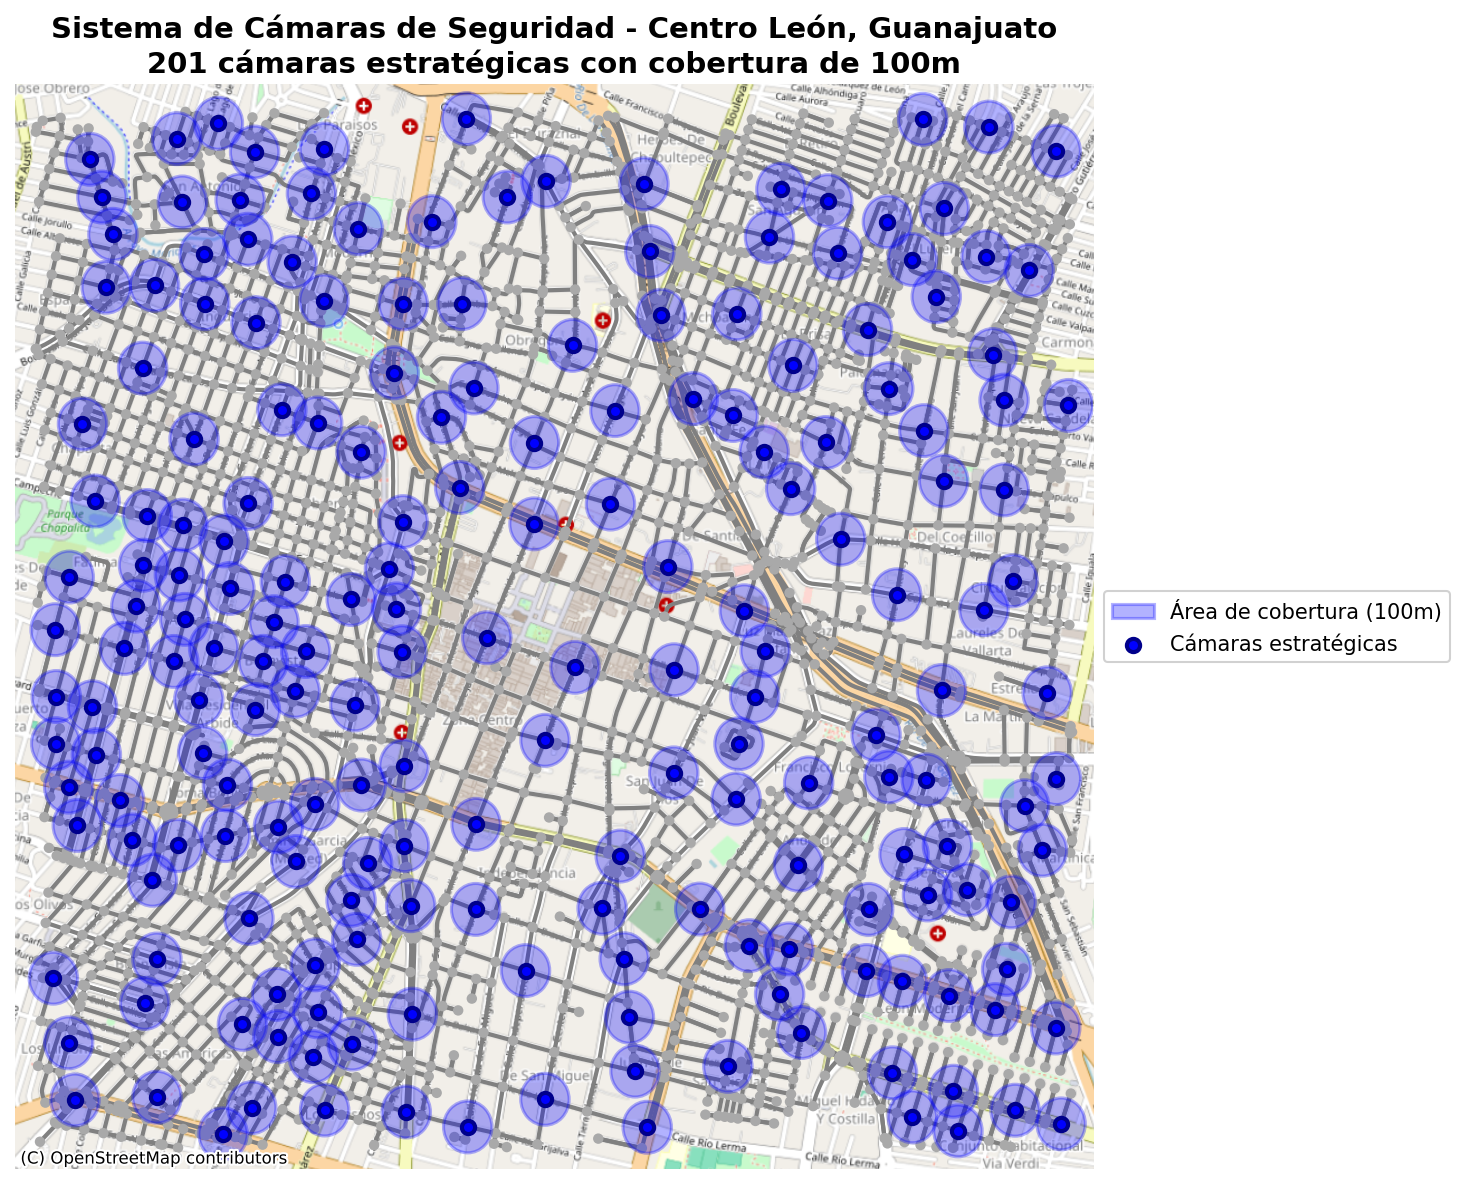

Área cubierta por las cámaras: 6.31 km2
Porcentaje del área total cubierta: 39.65%


In [5]:
# Visual 
fig, ax = plt.subplots(figsize=(11, 8), dpi=150)  
ox.plot_graph(G, ax=ax, show=False, close=False, 
              node_color='darkgray', node_size=25,
              edge_color='gray', edge_linewidth=2,
              bgcolor='black')
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik) # Mapa base OpenStreetMap

# Dibujar círculos de cobertura
radio_cobertura = 0.0009 # 100 metros aprox, por grado

for nodo in nodos_importantes:
    x = G.nodes[nodo]['x']
    y = G.nodes[nodo]['y']
    
    circulo = Circle((x, y), radio_cobertura, 
                    fill=True, alpha=0.3, color='blue',
                    edgecolor='darkblue', linewidth=1.5,
                    label='Área de cobertura (100m)' if nodo == nodos_importantes[0] else "")
    ax.add_patch(circulo)

# Nodos importantes
nodos_x = [G.nodes[nodo]['x'] for nodo in nodos_importantes]
nodos_y = [G.nodes[nodo]['y'] for nodo in nodos_importantes]

# Se utilizan las coordenadas de los nodos importantes para el scatter plot
ax.scatter(nodos_x, nodos_y, c='blue', s=40, zorder=3, 
          label='Cámaras estratégicas', edgecolors='darkblue', linewidth=2) 

plt.title(f'Sistema de Cámaras de Seguridad - Centro León, Guanajuato\n'
          f'{len(nodos_importantes)} cámaras estratégicas con cobertura de 100m',
          fontsize=14, fontweight='bold', color='Black')
ax.title.set_color('black')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), 
           fontsize=10, facecolor='white', labelcolor='black',
           framealpha=0.9)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# Area cubierta
area_cubierta = len(nodos_importantes) * math.pi * (0.1**2)  # en km
porcentaje_cubierto = (area_cubierta / area_km_cuadrados) * 100


print(f"Área cubierta por las cámaras: {area_cubierta:.2f} km2")
print(f"Porcentaje del área total cubierta: {porcentaje_cubierto:.2f}%")




## Agrupamiento de los nodos seleccionados
Se agrupan en sub-regiones

In [6]:
def kmeans(nodos, k, max_iters=100):
    # Inicializar centroides aleatoriamente
    np.random.seed(42)
    centros = nodos[np.random.choice(nodos.shape[0], k, replace=False)]
    
    for i in range(max_iters):
        # Asignar puntos al centroide más cercano
        distancias = np.linalg.norm(nodos[:, np.newaxis] - centros, axis=2) 
        labels = np.argmin(distancias, axis=1) 
        
        # Actualizar centroides
        new_centros = np.array([nodos[labels == j].mean(axis=0) for j in range(k)])
        # Verificar convergencia
        if np.all(centros == new_centros):
            break
        centros = new_centros

    # Después de converger, encontrar los nodos reales más cercanos a los centroides
    centros_nodos_reales_cord = []
    centros_nodos_ID = []
    for centro in centros:
        # Calcular distancia de este centroide a todos los nodos
        distancias = np.linalg.norm(nodos - centro, axis=1)
        # Seleccionar el nodo más cercano
        nodo_mas_cercano_idx = np.argmin(distancias)  # Índice del nodo más cercano
        centros_nodos_reales_cord.append(nodos[nodo_mas_cercano_idx])
        nodo_mas_cercano = nodos_importantes[nodo_mas_cercano_idx]
        centros_nodos_ID.append(nodo_mas_cercano)
        

    return np.array(centros_nodos_reales_cord), centros_nodos_ID, labels


data = []
for nodo in nodos_importantes:
    x = G.nodes[nodo]['x']
    y = G.nodes[nodo]['y']
    data.append([x, y])
data = np.array(data)
k = 5  # Número de clusters
centros, centros_nodos_ID, labels = kmeans(data, k)

print(centros_nodos_ID)

[351531834, 2358755322, 484967685, 349280492, 485108387]


In [7]:
print(centros)
# Cantidad de nodos por cluster
for i in range(k):
    cantidad_nodos = np.sum(labels == i)
    print(f"Cluster {i+1}: {cantidad_nodos} nodos")

[[-101.6946626   21.1213669]
 [-101.6908816   21.1103823]
 [-101.6703472   21.132417 ]
 [-101.6703055   21.1123049]
 [-101.6905582   21.1334111]]
Cluster 1: 41 nodos
Cluster 2: 38 nodos
Cluster 3: 39 nodos
Cluster 4: 47 nodos
Cluster 5: 36 nodos


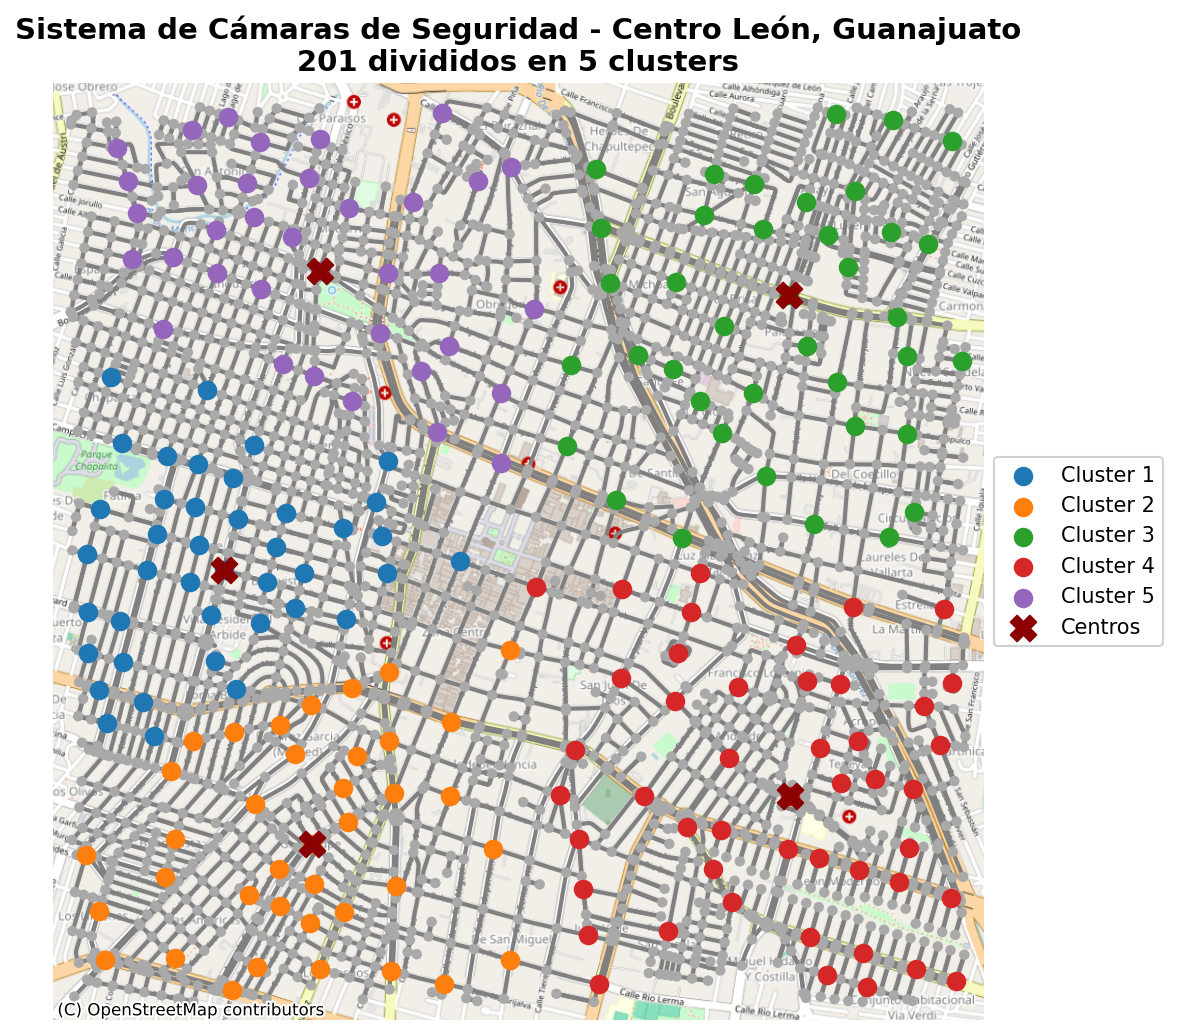

In [8]:
# Visualizar clusters
fig, ax = plt.subplots(figsize=(9, 7), dpi=150)  
ox.plot_graph(G, ax=ax, show=False, close=False, 
              node_color='darkgray', node_size=25,
              edge_color='gray', edge_linewidth=2,
              bgcolor='black')
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
for i in range(k):
    puntos_del_cluster = data[labels == i]
    plt.scatter(puntos_del_cluster[:, 0], puntos_del_cluster[:, 1], label=f'Cluster {i + 1}', s=70)
plt.scatter(centros[:, 0], centros[:, 1], s=150, c='darkred', marker='X', label='Centros', zorder=5)

plt.title(f'Sistema de Cámaras de Seguridad - Centro León, Guanajuato\n'
          f'{len(nodos_importantes)} divididos en {k} clusters',
          fontsize=14, fontweight='bold', color='Black')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), 
           fontsize=10, facecolor='white', labelcolor='black',
           framealpha=0.9)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

### Construcción de árboles mínimos dentro de cada grupo
Algoritmo a utilizar: Prim

In [9]:

def reconstruir_ruta(previo, destino):
    ruta = []
    nodo_actual = destino
    
    while nodo_actual is not None:
        ruta.append(nodo_actual)
        nodo_actual = previo[nodo_actual]
    
    # Inverimos para tener origen -> destino
    return ruta[::-1]


def heuristica(nodo_a, nodo_b): # Distancia euclidiana para A*
    x1, y1 = G.nodes[nodo_a]['x'], G.nodes[nodo_a]['y']
    x2, y2 = G.nodes[nodo_b]['x'], G.nodes[nodo_b]['y']
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    
def calcular_ruta_a_estrella(origen, destino):
    if origen == destino:
        return [origen]
    
    # Costo acumulado desde el inicio hasta cada nodo
    costo_desde_inicio = {n: float('inf') for n in G.nodes}
    costo_desde_inicio[origen] = 0
    
    # Estimación total
    estimacion_total = {n: float('inf') for n in G.nodes}
    estimacion_total[origen] = heuristica(origen, destino)
    
    # Punteros para reconstruir la ruta
    nodo_previo = {n: None for n in G.nodes}
    
    # Conjunto de nodos ya procesados
    nodos_cerrados = set()
    
    # Cola de prioridad para A*
    frontera = [(estimacion_total[origen], origen)]
    
    while frontera:
        _, nodo_actual = heapq.heappop(frontera)
        
        if nodo_actual in nodos_cerrados:
            continue
        
        nodos_cerrados.add(nodo_actual)
        
        if nodo_actual == destino:
            return reconstruir_ruta(nodo_previo, destino)
        
        for vecino in G.neighbors(nodo_actual):
            if vecino in nodos_cerrados:
                continue
            
            # Costo real por moverte de actual → vecino
            longitud_arista = G[nodo_actual][vecino][0].get('length', 1)
            costo_tentativo = costo_desde_inicio[nodo_actual] + longitud_arista
            
            if costo_tentativo < costo_desde_inicio[vecino]:
                nodo_previo[vecino] = nodo_actual
                costo_desde_inicio[vecino] = costo_tentativo
                estimacion_total[vecino] = costo_tentativo + heuristica(vecino, destino)
                
                heapq.heappush(frontera, (estimacion_total[vecino], vecino))
    
    return None


# Función Prim
def prim_mst_rutas_reales(origen, nodos_cluster):
    nodos_pend = set(nodos_cluster)
    nodos_pend.remove(origen)

    visitados = {origen}
    aristas_mst = []  
    total = 0

    while nodos_pend:
        mejor_arista = None
        mejor_ruta = None
        mejor_peso = float('inf')

        for u in visitados:
            for v in nodos_pend:
                ruta = calcular_ruta_a_estrella(u, v)
                if ruta:
                    # Calcular distancia real de la ruta
                    peso = sum(G[ruta[i]][ruta[i+1]][0]['length'] for i in range(len(ruta)-1))
                    
                    if peso < mejor_peso:
                        mejor_peso = peso
                        mejor_arista = (u, v)
                        mejor_ruta = ruta

        if mejor_arista:
            u, v = mejor_arista
            aristas_mst.append((u, v, mejor_peso, mejor_ruta))
            total += mejor_peso

            visitados.add(v)
            nodos_pend.remove(v)
        else:
            break

    return visitados, aristas_mst, total


Distancia total del Cluster 1: 11475.53 metros
Distancia total del Cluster 2: 11268.58 metros
Distancia total del Cluster 3: 16565.54 metros
Distancia total del Cluster 4: 14654.10 metros
Distancia total del Cluster 5: 11673.98 metros


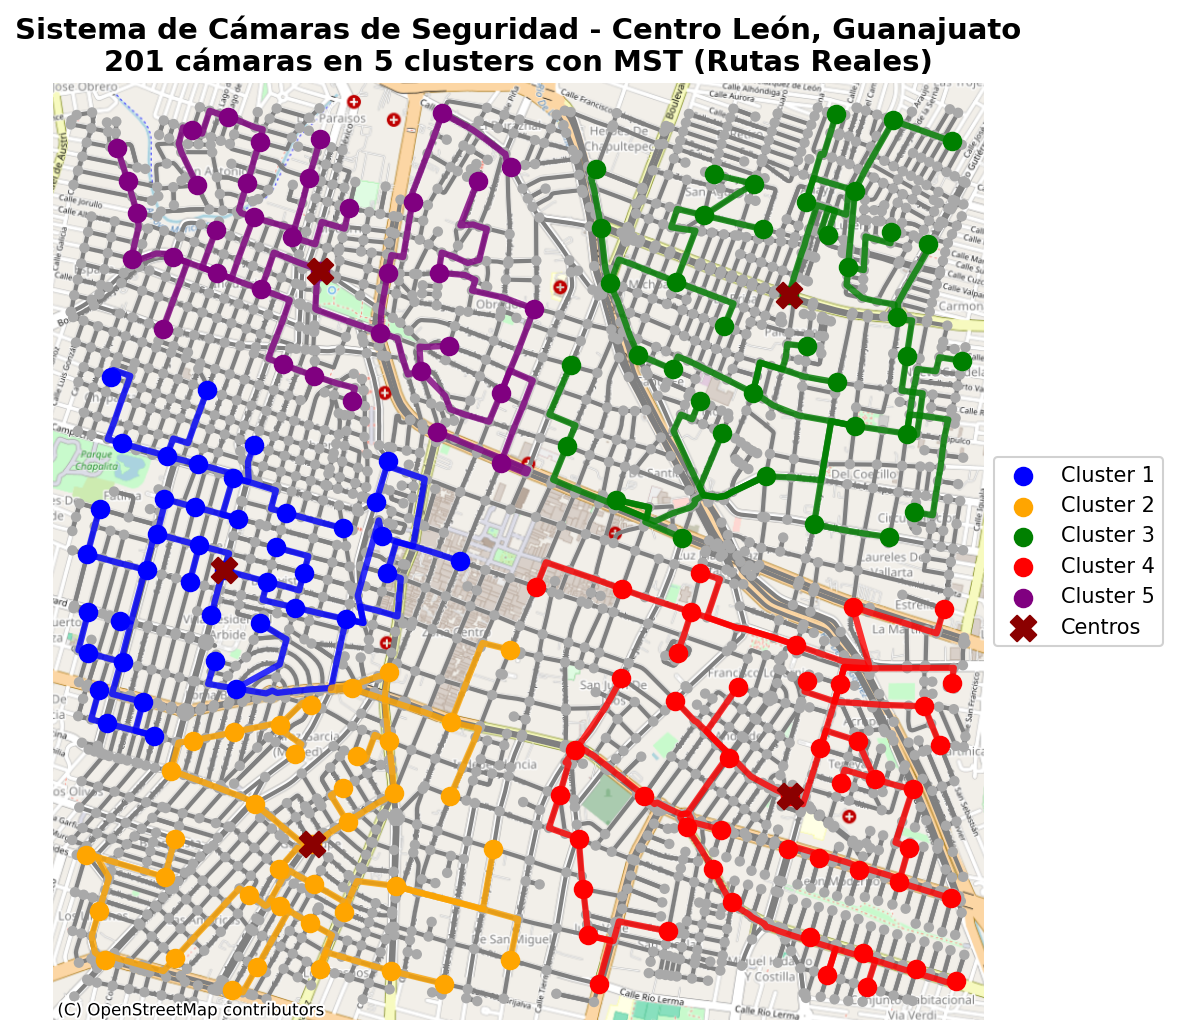

In [10]:
fig, ax = plt.subplots(figsize=(9, 7), dpi=150)
ox.plot_graph(G, ax=ax, show=False, close=False, 
              node_color='darkgray', node_size=25,
              edge_color='gray', edge_linewidth=2,
              bgcolor='black')

ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

# Colores para los clusters
colores = ['blue', 'orange', 'green', 'red', 'purple']

for i in range(k):
    puntos_del_cluster = data[labels == i]
    
    # Encontrar los nodos correspondientes en el grafo
    nodos_cluster = []
    for punto in puntos_del_cluster:
        for nodo in nodos_importantes:
            if (abs(G.nodes[nodo]['x'] - punto[0]) < 0.0001 and 
                abs(G.nodes[nodo]['y'] - punto[1]) < 0.0001):
                nodos_cluster.append(nodo)
                break
    
    if len(nodos_cluster) < 2:
        continue
  
    origen_cluster = centros_nodos_ID[i]
    
    # Calcular MST con rutas reales
    nodos_mst, aristas_mst, total = prim_mst_rutas_reales(origen_cluster, nodos_cluster)
    print(f"Distancia total del Cluster {i + 1}: {total:.2f} metros")
    
    # Dibujar puntos del cluster
    color_cluster = colores[i % len(colores)]
    cluster_x = [G.nodes[n]['x'] for n in nodos_cluster]
    cluster_y = [G.nodes[n]['y'] for n in nodos_cluster]
    plt.scatter(cluster_x, cluster_y, c=color_cluster, 
                label=f'Cluster {i + 1}', s=70, zorder=4)

    for (u, v, peso, ruta) in aristas_mst:
        if ruta:
            x_ruta = [G.nodes[nodo]['x'] for nodo in ruta]
            y_ruta = [G.nodes[nodo]['y'] for nodo in ruta]
            
            plt.plot(x_ruta, y_ruta, c=color_cluster, 
                    linewidth=3, alpha=0.8, zorder=3,
                    linestyle='-', marker='')

plt.scatter(centros[:, 0], centros[:, 1], s=150, c='darkred', 
           marker='X', label='Centros', zorder=5)

plt.title(f'Sistema de Cámaras de Seguridad - Centro León, Guanajuato\n'
          f'{len(nodos_importantes)} cámaras en {k} clusters con MST (Rutas Reales)',
          fontsize=14, fontweight='bold', color='Black')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), 
           fontsize=10, facecolor='white', labelcolor='black',
           framealpha=0.9)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [11]:
# Cobertura total 100 metros por nodo de cada cluster
def area_cubierta_cluster(num_nodos, radio_km=0.1):
    return num_nodos * math.pi * (radio_km ** 2) 

for i in range(k):
    puntos_del_cluster = data[labels == i]
    num_nodos = len(puntos_del_cluster)
    area_cubierta = area_cubierta_cluster(num_nodos)
    porcentaje_cubierto = (area_cubierta / area_km_cuadrados) * 100
    print(f"Cluster {i + 1}: Área cubierta = {area_cubierta:.2f} km2, Porcentaje del área total = {porcentaje_cubierto:.2f}%")

Cluster 1: Área cubierta = 1.29 km2, Porcentaje del área total = 8.09%
Cluster 2: Área cubierta = 1.19 km2, Porcentaje del área total = 7.50%
Cluster 3: Área cubierta = 1.23 km2, Porcentaje del área total = 7.69%
Cluster 4: Área cubierta = 1.48 km2, Porcentaje del área total = 9.27%
Cluster 5: Área cubierta = 1.13 km2, Porcentaje del área total = 7.10%
